# Inference

The inference over parameters behind a collection of ratings is carried out employing Sequential Neural Posterior Estimation (SNPE), which is implemented in this project by the [`sbi`](https://www.mackelab.org/sbi/) (acronym for Simulation Based Inference) package. 

This notebooks explores the process behind building a posterior distribution employing SNPE and simulated training data to the get conditioned samples from it. First the training of the neural posterior estimator and the building of a posterior distribution from it will be reviewed. After that, posterior samples will be obtained from this distribution conditioned on both observed and simulated ratings data.

### A. Imports and preliminary steps

First of all, the relevant imports are carried out in the cell below.

In [1]:
%load_ext autoreload
%autoreload 2

# Just a formatting related plugin
#%load_ext nb_black

%matplotlib inline
import matplotlib.pyplot as plt

import sys

sys.path.append("../")

import multiprocessing as mp

from collections import deque
from pathlib import Path
from typing import Dict, Optional

import arviz
import pickle

import numpy as np
import pandas as pd
import pyreadr
import sbi
import sbi.utils as sbi_utils
import seaborn as sns
import statsmodels.formula.api as smf
import torch

from joblib import Parallel, delayed
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
from snpe.inference import inference_class
from snpe.simulations import simulator_class, marketplace_simulator_class
from snpe.embeddings.embeddings_to_ratings import EmbeddingRatingPredictor
from snpe.utils.statistics import review_histogram_correlation
from snpe.utils.tqdm_utils import tqdm_joblib
from tqdm import tqdm

# Set plotting parameters
sns.set(style="white", context="talk", font_scale=2.5)
sns.set_color_codes(palette="colorblind")
sns.set_style("ticks", {"axes.linewidth": 2.0})

Then the `ARTIFACT_PATH` is defined, where most the relevant inputs/outputs related to the task of carried out in the notebook will be retrieved/stored. You can modify it at your convenience.

Moreover a second `SAMPLING_SIMULATION_PATH` is defined, this is the path where simulation data for conditional sampling will be retrieved from during section D. of the notebook. 

In [2]:
ARTIFACT_PATH = Path("../../../bucket/data")
SAMPLING_SIMULATION_PATH = Path("../../../bucket/large_data")

### B. Training the estimator and building a posterior distribution

The first step to conduct inference over the parameters of a timeseries of ratings under the methodology here considered is to train the neural estimator. Firstly, this function initializes two tensors containing the upper and lower bounds of the parameter distributions are to be provided to the estimator during training. In this case such tensors define the upper and lower bounds of the distributions of 8 different parameters, being that the number of parameters considered in marketplace (rating scale) simulations, which is the kind of simulation that will be used as reference throughout this notebook alongside the parameters it contemplates.

Then, in this case a previously simulated marketplace timeseries is loaded by `infer_and_save_posterior` to act as training data. Subsequently the `infer_snpe_posterior` method of the inference class (TimeSeriesInference in this particular case) is called. This method is in charge of both, training the nerual sequential posterior estimator and building a posterior distribution from the density estimator obtained after the training phase. Finally the posterior distribution is saved for later use in conditional sampling.

The arguments to provide to `infer_and_save_posterior` are the following:

- `device`: Device where the posterior net will be trained. Must be a string, either 'cuda' or 'cpu'.


- `simulator_type`: Type of the simulator to be loaded by the inferrer (e.g. double_herding, marketplace...).


- `simulation_type`: Modality of simulation that will be loaded. Must be str 'timeseries' or 'histogram'.


- `params`: Dictionary of parameters to configure the posterior net.

As an extra piece of information, it is also worth mentioning that the inferrer's `infer_snpe_posterior` method can be provided with additional arguments not covered within the scope of `infer_and_save_posterior` and this notebook. These include:

- `embedding_net_creator` (Optional): A function-like embedding net creator whose parameter are given by `embedding_net_conf`. If not provided the default embedding net creator will be `torch.nn.Identity()`.


- `simulation_transform` (Optional): A function like object in charge of transforming the simulation data in the desired manner. If not provided, simulation data will be converted into pytorch tensors.


- `model`: Type of density estimator to be used by sbi. It should be one of the following (str): "mdn", "made", "maf", "nsf". "maf" is the default estimator to employ.

In [3]:
def infer_and_save_posterior(
    device: str, simulator_type: str, simulation_type: str, params: Dict
) -> None:
    parameter_prior = sbi_utils.BoxUniform(
        low=torch.tensor([0.0, 0.0, 0.0, 0.5, 0.25, 0.25, 0.5, 0.0]).type(
            torch.FloatTensor),
        high=torch.tensor([4.0, 4.0, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0]).type(
            torch.FloatTensor),
        device=device)
    
    inferrer = inference_class.TimeSeriesInference(
        parameter_prior=parameter_prior, device=device)
    
    inferrer.load_simulator(
        dirname=ARTIFACT_PATH,
        simulator_type=simulator_type,
        simulation_type=simulation_type)
    
    batch_size = params.pop("batch_size")
    learning_rate = params.pop("learning_rate")
    hidden_features = params.pop("hidden_features")
    num_transforms = params.pop("num_transforms")
    inferrer.infer_snpe_posterior(
        embedding_net_conf=params,
        batch_size=batch_size,
        learning_rate=learning_rate,
        hidden_features=hidden_features,
        num_transforms=num_transforms)
    
    inferrer.save_inference(ARTIFACT_PATH)

Below the dictionary of hyperparameters to configure posterior net that will be provided as an argument to `infer_and_save_posterior` is defined. These have been previously obtained by carrying out a hyperparameter tuning procedure.



In [4]:
inference_params = {
    "batch_size": 256,
    "learning_rate": 3.67e-4,
    "hidden_features": 40,
    "num_transforms": 8,
    "num_conv_layers": 2,
    "num_channels": 9,
    "conv_kernel_size": 13,
    "maxpool_kernel_size": 9,
    "num_dense_layers": 3,
}

With all the ingredients in place `infer_and_save_posterior` is called. In this case and according to the provided parameters, timeseries of a marketplace simulation are employed as training data. The training of the posterior estimator will stop automatically once convergence has been reached.


In [5]:
infer_and_save_posterior("cpu", "marketplace", "timeseries", inference_params)

	 Device set to cpu, using torch num threads=32
Embedding net created: 
 Sequential(
  (0): Conv1d(5, 9, kernel_size=(13,), stride=(1,), padding=(6,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv1d(9, 9, kernel_size=(13,), stride=(1,), padding=(12,), dilation=(2,))
  (3): MaxPool1d(kernel_size=9, stride=9, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=558, out_features=128, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=128, out_features=64, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=64, out_features=32, bias=True)
)
 Neural network successfully converged after 206 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 206
        Best validation performance: 2.9201
        -------------------------
        


### C. Posterior sampling conditioned on observed data

After the posterior net has been trained and the posterior distribution built, now it is posible to get samples from it conditioned on a series of provided observations. In this particular case, as its name suggests, the function `sample_posterior_with_observed` is designed to get samples from the posterior distribution conditioned on a provided set of observed ratings. 

For that, `sample_posterior_with_observed` will load the posterior distribution previously built and saved by `infer_and_save_posterior` to then call the inferrer class' method `get_posterior_samples`. This method takes the conditioned samples on the basis of the provided observed ratings and according to the arguments specified to the `sample_posterior_with_observed`. These are:

- `device`: Device where the sampling operation will take place. Must be a string, either 'cuda' or 'cpu'.


- `observations`: Numpy array of type timeseries/histogram (Observed) to condition the sampling. 


- `num_samples`: Number of samples of each parameter to take from the built posterior.


- `simulator_type`: Type of simulator to be loaded by the inferrer instance in charge of drawing the samples (e.g. double_herding, marketplace...). Given that `sample_posterior_with_observed` works with observed data, the relevance of this argument comes from the fact that it defines the number of parameters that should be sampled from the distribution.


- `simulation_type`: Modality of the data that will be used to condition the sampling procedure. Must be a string, either 'timeseries' or 'histogram'. Although `sample_posterior_with_observed` will not work with simulated data, this parameter refers to the word "simulation" because the format of the data to be loaded has to be be equivalent to either the 'histogram' or 'timeseries' ones that are produced by the different kinds of simulators.


The function returns a numpy array of the shape (num_samples, number_of_products_in_observations, number_of_parameters) with the sampled posteriors.

In [6]:
def sample_posterior_with_observed(
    device: str,
    observations: np.array,
    num_samples: int,
    simulator_type: str,
    simulation_type: str,
) -> np.ndarray:
    # The parameter prior doesn't matter here as it will be overridden by that of the loaded inference object
    parameter_prior = sbi.utils.BoxUniform(
        low=torch.tensor([0.0, 0.0, 0.0, 0.5, 0.25, 0.25, 0.5, 0.0]).type(
            torch.FloatTensor
        ),
        high=torch.tensor([4.0, 4.0, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0]).type(
            torch.FloatTensor
        ),
        device=device,
    )
    inferrer = inference_class.TimeSeriesInference(
        parameter_prior=parameter_prior, device=device
    )
    inferrer.load_simulator(
        dirname=ARTIFACT_PATH,
        simulator_type=simulator_type,
        simulation_type=simulation_type,
    )
    inferrer.load_inference(dirname=ARTIFACT_PATH)
    posterior_samples = inferrer.get_posterior_samples(
        observations, num_samples=num_samples
    )
    return posterior_samples

In the example below, `sample_posterior_with_observed` is set to get parameter samples from the posterior distribution conditioned on an timeseries of observed ratings (`timeseries_data`) which is imported in the cell below immediately before actually calling the sampling function. 500 samples will be taken for each product and parameter. Given that the argument `simulation_type` is set as 'marketplace' the function will take samples for the 8 differnet parameters contemplated in such setting. 

Bear in mind that the maximum length of the timeseries of ratings for each product in the data that will condition the sampling procdure cannot be larger than the maximum one employed to train the posterior net. If this is the case you should restrict the length of the provided timeseries that exceed this limit to match it before you load and pass them to `sample_posterior_with_observed`.

In [7]:
timeseries_data = np.load(ARTIFACT_PATH / 'timeseries_data.npy', allow_pickle=True)

In [8]:
posterior_samples = sample_posterior_with_observed(
    "cpu", timeseries_data, 500, "marketplace", "timeseries")

	 Device set to cpu, using torch num threads=32


#### C.1. Plotting the mean posteriors

With the aim of visualizing the distribution of the mean posteriors sampled, the following function `plot_mean_posteriors_for_products` is defined. Focused around the rho ($\rho$+ and $\rho$-) and herding parameters, `plot_mean_posteriors_for_products` computes the mean across all samples of these parameters for each product and plots these on two histograms.

In [9]:
def plot_mean_posteriors_for_products(posterior_samples: np.ndarray) -> None:
    fig, ax = plt.subplots(1, 2, squeeze=False)
    ax[0, 0].hist(
        np.mean(posterior_samples[:, :, 0], axis=0),
        color=sns.xkcd_rgb["cerulean"],
        alpha=0.5,
        bins=10,
        label=r"$\rho_{-}$",
    )
    ax[0, 0].hist(
        np.mean(posterior_samples[:, :, 1], axis=0),
        color=sns.xkcd_rgb["dark orange"],
        alpha=0.5,
        bins=10,
        label=r"$\rho_{+}$",
    )
    ax[0, 1].hist(
        np.mean(posterior_samples[:, :, 2], axis=0),
        color=sns.xkcd_rgb["black"],
        alpha=0.5,
        bins=10,
        label=r"$h_p$",
    )
    ax[0, 0].legend(fontsize=10)
    ax[0, 1].legend(fontsize=10)
    ax[0, 0].set_xticks([0, 1, 2, 3, 4])
    ax[0, 1].set_xticks([0, 0.5, 1])
    ax[0, 0].tick_params(axis="both", labelsize=8)
    ax[0, 1].tick_params(axis="both", labelsize=8)
    # add a big axis, hide frame
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor="none", top=False, bottom=False, left=False, right=False)
    # plt.xlabel(r"$\rho_{-}, \rho_{+}$")
    plt.ylabel(
        f"Number of products (Total = {posterior_samples.shape[1]})", fontsize=15
    )
    #fig.tight_layout()
    fig.savefig(ARTIFACT_PATH / "mean_posteriors.png", bbox_inches="tight")

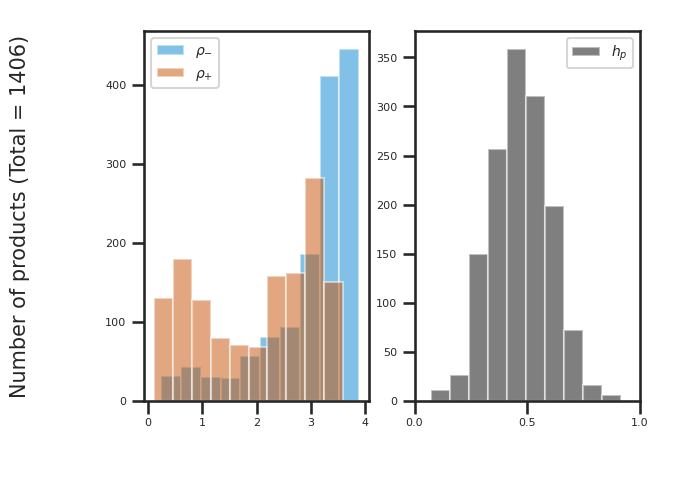

In [10]:
plot_mean_posteriors_for_products(posterior_samples)

### D. Posterior sampling conditioned on simulation data

If instead of taking samples from the posterior distribution conditioned on observed data, we would like to do it from simulated data, the `sample_posterior_on_simlations` function is designed to do that. This function works in a similar manner to `sample_posterior_with_observed` with the main difference that instead of employing some observed 'external' ratings data provided by us, it will load a simlation stored in SAMPLING_SIMULATION_PATH (defined at the beggining of the notebook). 

It is also worth considering that `sample_posterior_on_simlations` is built in such a way in which, if a marketplace simulation with N marketplaces is loaded, only one (the first) of these marketplaces will be considered during sampling. 

The arguments governing this function are the same as those of `sample_posterior_with_observed`, with the exception of the new argument `max_inference_length`. This argument is understood from the fact that `sample_posterior_on_simulated` will automatically restrict the length of any timeseries in the loaded simulation that may exceed the maximum one considered at the time of training the posterior net. That maximum training timeseries length must be specified as the value for `max_inference_length` so the lenght adjustment of the loaded timeseries can be carried out appropriately.



In [11]:
# In marketplace simulations, we cannot just supply a set of rho params, then simulate and infer on these simulations
# to test if the inference can recover the initially provided params
# So we instead sample from the posterior of a separate set of marketplace simulations not used in training and see
# if parameters are recovered on this new set
def sample_posterior_on_simulations(
    device: str,
    num_samples: int,
    simulator_type: str,
    simulation_type: str,
    max_inference_length: int,
) -> np.ndarray:
    # We load the larger simulation (over 64 marketplaces) as the separate simulation for the inference to be tested on
    params = {
        "review_prior": np.ones(5),
        "tendency_to_rate": 0.05,
        "simulation_type": simulation_type,
        "previous_rating_measure": "mode",
        "min_reviews_for_herding": 5,
        "num_products": 1400,
        # "num_products": 100,
        "num_total_marketplace_reviews": 300_000,
        # "num_total_marketplace_reviews": 5_000,
        "consideration_set_size": 5,
        "previous_rating_measure": "mean",
        "min_reviews_for_herding": 5,
        "one_star_lowest_limit": -1.5,
        "five_star_highest_limit": 1.5,
        "max_bias_5_star": 0.5,
    }
    simulator = marketplace_simulator_class.MarketplaceSimulator(params)
    #simulator.load_simulator(ARTIFACT_PATH / "../large_data")
    simulator.load_simulator(SAMPLING_SIMULATION_PATH)
    # We pick all simulations from a single marketplace as the observations on which we wish to obtain
    # posterior samples
    # These are the observations for the posterior sampling function defined above
    observations = simulator.simulations[0]
    # Also pick the simulation parameters corresponding to these simulations
    simulation_params = simulator.simulation_parameters.copy()
    simulation_params["rho"] = simulation_params["rho"][: len(observations), :]
    simulation_params["h_p"] = simulation_params["h_p"][: len(observations)]
    # Cut the observations to the max length seen during SNPE training
    observations = np.array(
        [obs[:max_inference_length, :] for obs in observations], dtype="object"
    )
    posterior_samples = sample_posterior_with_observed(
        device, observations, num_samples, simulator_type, simulation_type
    )
    return posterior_samples, simulation_params

In the example below, `sample_posterior_on_simulation` is set to get parameter samples from the posterior distribution conditioned on an timeseries of simulated reviews. 500 samples will be taken for each product and parameter. Given that the argument `simulation_type` is set as 'marketplace' the function will take samples for the 8 differnet parameters contemplated in such setting. Moreover, `max_inference_length` has been set to 563, which was the maximum length of present in the training set of the posterior net in section B. of the notebook.

In [12]:
posterior_simulations, simulation_parameters = sample_posterior_on_simulations(
    "cpu", 500, "marketplace", "timeseries", 563)

	 Device set to cpu, using torch num threads=32


#### D.1. Plotting the mean posteriors

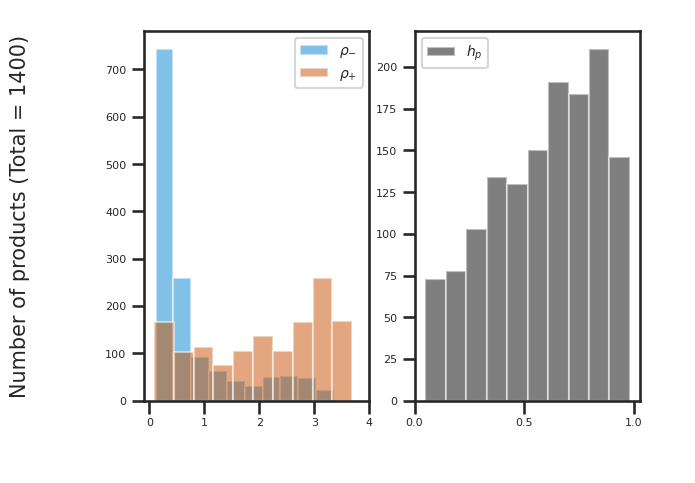

In [13]:
plot_mean_posteriors_for_products(posterior_simulations)